#### Want to create a model of how particle behave if they were evenly distributed verticlaly throughout the sytning and allowed to fall. How does this changes across size class -- what does this mean when coupled with look time both average inhibit time and prob looking


### Subgoals
1. model single cell size falling through time and space
2. generalize this function and do for variety of sizes
3. Randomly distribute different size classes throughout the syringe and see again
4. tryto relate this to inhibit time -- could we model in this simple version how many cells we miss



## 1. model single cell size basically need to create data frame with each cell at all positions and progress through time based on stokes setlting

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def stokes_terminal_velocity(diameter_um: float,
                             rho_particle: float,
                             rho_fluid: float,
                             mu: float,
                             g: float) -> float:
    """Stokes' settling velocity for a sphere at low Reynolds number (m/s)."""
    d_m = diameter_um * 1e-6  # µm -> m
    delta_rho = max(rho_particle - rho_fluid, 0.0)
    return (delta_rho * g * d_m**2) / (18.0 * mu)

def evenly_distributed_initial_positions(num: int, height_m: float) -> np.ndarray:
    """Centers of evenly spaced bins from bottom (0) to top (H)."""
    if num <= 0:
        return np.array([])
    edges = np.linspace(0.0, height_m, num + 1)
    return 0.5 * (edges[:-1] + edges[1:])

# -----------------
# Function 1: build the simulation dataframe
# -----------------
def simulate_settling_dataframe(cell_diameter_um: float,
                                num_cells: int,
                                syringe_height_cm: float,
                                cell_density: float = 1100.0,     # kg/m^3 this is density of each cell not cells/ml
                                fluid_density: float = 997.0,     # kg/m^3 water @ ~25°C
                                fluid_viscosity: float = 0.00089, # Pa·s
                                gravity: float = 9.81,            # m/s^2
                                num_time_steps: int = 200):
    """
    Returns:
        df: tidy DataFrame with columns [time_s, particle_id, y_m, has_hit_bottom]
        times: 1D array of time points (s)
        cum_bottom: 1D array with cumulative count of particles that have reached bottom by each time
    """
    H_m = syringe_height_cm / 100.0
    v = stokes_terminal_velocity(cell_diameter_um, cell_density, fluid_density, fluid_viscosity, gravity)
    # time horizon: allow enough time for top particle to reach bottom (+5%)
    t_max = (H_m / v) * 1.05 if v > 0 else 1.0
    times = np.linspace(0.0, t_max, num_time_steps)

    # initial positions and deterministic settling
    y0 = evenly_distributed_initial_positions(num_cells, H_m)
    if len(y0) > 0:
        Y = np.maximum(0.0, y0[None, :] - v * times[:, None])
        t_hit_each = (y0 / v) if v > 0 else np.full_like(y0, np.inf)
    else:
        Y = np.zeros((len(times), 0))
        t_hit_each = np.array([])

    # cumulative hits vs time
    cum_bottom = np.array([(t_hit_each <= t).sum() for t in times])

    # tidy dataframe
    df = pd.DataFrame({
        "time_s": np.repeat(times, len(y0)),
        "particle_id": np.tile(np.arange(1, len(y0) + 1), len(times)),
        "y_m": Y.flatten(order="C")
    })
    if len(y0) > 0:
        df["has_hit_bottom"] = df.apply(lambda r: r["time_s"] >= t_hit_each[int(r["particle_id"])-1], axis=1)
    else:
        df["has_hit_bottom"] = np.array([], dtype=bool)

    return df, times, cum_bottom

# -----------------
# Function 2: plot the cumulative arrivals at bottom
# -----------------
def plot_cumulative_bottom(times: np.ndarray, cum_bottom: np.ndarray, title: str = "Cumulative particles at bottom over time", save_path: str = None):
    """Simple matplotlib plot for cumulative arrivals."""
    plt.figure(figsize=(8, 5))
    plt.plot(times, cum_bottom)
    plt.xlabel("Time (s)")
    plt.ylabel("Particles at bottom (cumulative)")
    plt.title(title)
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path)
        print(f"Saved figure to {save_path}")
    plt.show()


In [2]:
df, times, cum_bottom = simulate_settling_dataframe(cell_diameter_um = 20,
                                num_cells = 100,
                                syringe_height_cm = 11.0998,
                                cell_density = 1100.0,     # kg/m^3 meaning density of a single particle -- does this vary between cell types?
                                fluid_density = 1025.0,     # kg/m^3 water @ ~25°C
                                fluid_viscosity = 0.00109, # Pa·s
                                gravity = 9.81,            # m/s^2
                                num_time_steps = 1200)

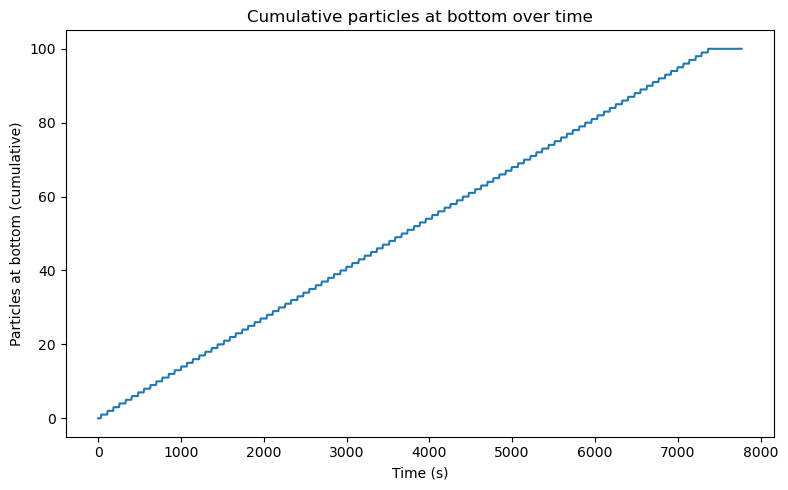

In [3]:
plot_cumulative_bottom(times, cum_bottom)

## I knew this was going to be linear -- its just basically showing that when all these particles fall at a static rate so there is no change in rate of them hitting the bottom

### more interesting -- i dont even think it's worth doing this for diff particle sizes what I want to know is if i randomly assign sizes evenly distributed throughout the whole verticle space what happens

In [4]:
# Multi-size settling simulation (Stokes) with random vertical positions
# Discrete size classes; per-particle settling based on assigned size.

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# -----------------
# Physics helper
# -----------------
def stokes_terminal_velocity(diameter_um: float,
                             rho_particle: float,
                             rho_fluid: float,
                             mu: float,
                             g: float) -> float:
    """
    Stokes' settling velocity for a sphere at low Reynolds number (m/s):
        v = ((rho_p - rho_f) * g * d^2) / (18 * mu)

    Parameters
    ----------
    diameter_um : float
        Particle diameter (micrometers).
    rho_particle : float
        Particle density (kg/m^3).
    rho_fluid : float
        Fluid density (kg/m^3).
    mu : float
        Dynamic viscosity (Pa·s).
    g : float
        Gravity (m/s^2).

    Returns
    -------
    float
        Terminal settling velocity in m/s (positive downward).
    """
    d_m = diameter_um * 1e-6
    delta_rho = max(rho_particle - rho_fluid, 0.0)
    return (delta_rho * g * d_m**2) / (18.0 * mu)

# -----------------
# Simulation
# -----------------
def simulate_settling_dataframe_mixture(
    sizes_um,                      # list/array of discrete diameters in µm
    num_cells: int,                # total number of particles
    syringe_height_cm: float,      # syringe height (cm)
    size_probs=None,               # optional probabilities for sizes (same length as sizes_um); defaults to uniform
    cell_density: float = 1050.0,  # kg/m^3
    fluid_density: float = 997.0,  # kg/m^3 (water @ ~25°C)
    fluid_viscosity: float = 0.00089, # Pa·s
    gravity: float = 9.81,         # m/s^2
    num_time_steps: int = 300,
    random_seed: int | None = 42
):
    """
    Randomly assigns each particle to one of the given discrete size classes (per size_probs),
    places particles at random initial heights (uniform in [0, H]), and simulates
    deterministic Stokes settling until they hit the bottom (y=0).

    Returns
    -------
    df : pd.DataFrame
        Tidy long-form table with columns:
        [time_s, particle_id, y_m, has_hit_bottom, size_um, v_m_per_s]
    times : np.ndarray
        Vector of time points (seconds).
    cum_bottom_total : np.ndarray
        Cumulative number of particles that have reached bottom at each time.
    cum_bottom_by_size : dict[float, np.ndarray]
        For each size class (µm), cumulative arrivals over time.
    For reconstructing events after:    
    t_hit_each: the exact time of each arival at the bottom used for merging to create useful datasets 
    size_assign: size class of each particle that hits the bottom related to t_hit_each
    """
    rng = np.random.default_rng(random_seed)
    H_m = syringe_height_cm / 100

    sizes_um = np.asarray(sizes_um, dtype=float)
    if size_probs is None:
        size_probs = np.ones_like(sizes_um) / len(sizes_um)
    else:
        size_probs = np.asarray(size_probs, dtype=float)
        size_probs = size_probs / size_probs.sum()

    # Assign a size class to each particle
    size_assign = rng.choice(sizes_um, size=num_cells, p=size_probs)

    # Random initial vertical positions, uniform along syringe height
    y0 = rng.uniform(0.0, H_m, size=num_cells)

    # Per-particle settling velocity
    v_each = np.array([
        stokes_terminal_velocity(d_um, cell_density, fluid_density, fluid_viscosity, gravity)
        for d_um in size_assign
    ])

    # Time horizon: slowest positive-velocity particle starting from top
    v_min_positive = v_each[v_each > 0].min() if np.any(v_each > 0) else 0.0
    t_max = (H_m / v_min_positive) * 1.05 if v_min_positive > 0 else 1.0
    times = np.linspace(0.0, t_max, num_time_steps)

    # Positions over time: y(t) = max(0, y0 - v_i * t)
    Y = np.maximum(0.0, y0[None, :] - times[:, None] * v_each[None, :])  # (T, N)

    # First-hitting times
    with np.errstate(divide='ignore', invalid='ignore'):
        t_hit_each = np.where(v_each > 0.0, y0 / v_each, np.inf)

    # Cumulative hits (total)
    cum_bottom_total = np.array([(t_hit_each <= t).sum() for t in times])

    # Cumulative hits (by size class)
    unique_sizes = np.unique(sizes_um)
    cum_bottom_by_size = {}
    for s in unique_sizes:
        mask = (size_assign == s)
        t_hits_s = t_hit_each[mask]
        cum_bottom_by_size[float(s)] = np.array([(t_hits_s <= t).sum() for t in times])

    # Tidy dataframe
    df = pd.DataFrame({
        "time_s": np.repeat(times, num_cells),
        "particle_id": np.tile(np.arange(1, num_cells + 1), len(times)),
        "y_m": Y.flatten(order="C"),
        "size_um": np.tile(size_assign, len(times)),
        "v_m_per_s": np.tile(v_each, len(times)),
    })
    # Mark whether a particle has reached bottom by each time
    df["has_hit_bottom"] = df["time_s"].values >= np.take(t_hit_each, df["particle_id"].values - 1)

    return df, times, cum_bottom_total, cum_bottom_by_size, t_hit_each, size_assign


# -----------------
# Plot helpers
# -----------------
def plot_cumulative_total(times: np.ndarray, cum_bottom_total: np.ndarray,
                          title: str = "Total cumulative particles at bottom",
                          save_path: str = None):
    plt.figure(figsize=(8, 5))
    plt.plot(times, cum_bottom_total)
    plt.xlabel("Time (s)")
    plt.ylabel("Particles at bottom (cumulative)")
    plt.title(title)
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path)
        print(f"Saved figure to {save_path}")
    plt.show()

def plot_cumulative_by_size(times: np.ndarray, cum_bottom_by_size: dict,
                            title: str = "Cumulative arrivals by size class",
                            save_path: str = None):
    plt.figure(figsize=(8, 5))
    for size_um, series in sorted(cum_bottom_by_size.items(), key=lambda kv: kv[0]):
        plt.plot(times, series, label=f"{size_um:.0f} µm")
    plt.xlabel("Time (s)")
    plt.ylabel("Particles at bottom (cumulative)")
    plt.title(title)
    plt.legend()
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path)
        print(f"Saved figure to {save_path}")
    plt.show()


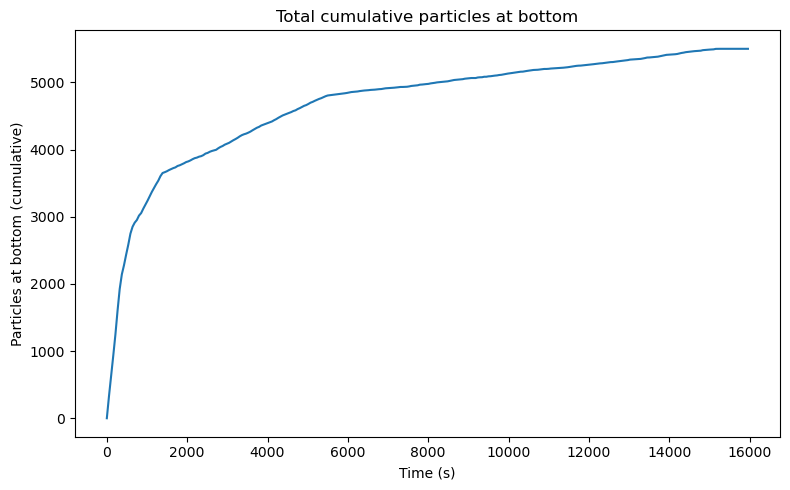

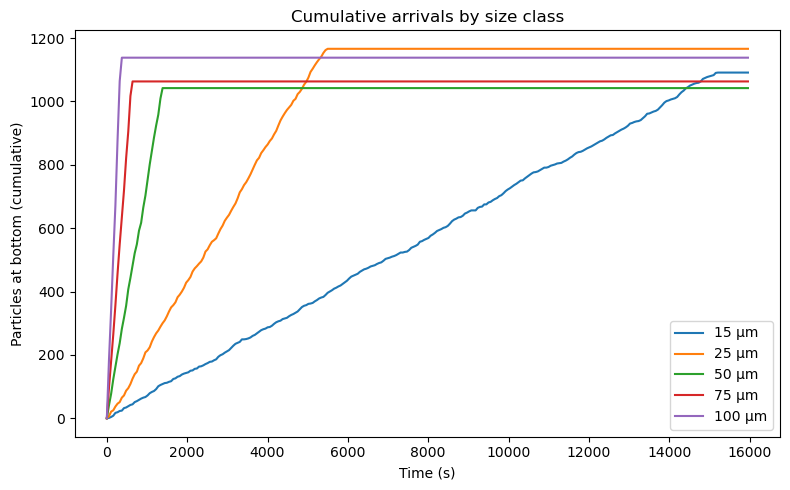

   time_s  particle_id       y_m  size_um  v_m_per_s  has_hit_bottom
0     0.0            1  0.064958     75.0   0.000183           False
1     0.0            2  0.097277    100.0   0.000325           False
2     0.0            3  0.095912     75.0   0.000183           False
3     0.0            4  0.078447     25.0   0.000020           False
4     0.0            5  0.036549     25.0   0.000020           False


In [6]:

# -----------------
# Minimal example usage
# -----------------
if __name__ == "__main__":
    sizes = [15, 25, 50, 75, 100]      # discrete size classes (µm)
    probs = [0.2, 0.2, 0.2, 0.2, 0.2]   # optional mixing probabilities (sum to 1)

    df_mix, times, cum_total, cum_by_size,t_hit_each, size_assign = simulate_settling_dataframe_mixture(
        sizes_um=sizes,
        num_cells=5500,
        syringe_height_cm=11.0998,
        size_probs=probs,
        cell_density=1050.0,
        fluid_density=997.0,
        fluid_viscosity=0.00089,
        gravity=9.81,
        num_time_steps=300,
        random_seed=7
    )

    # Plots
    plot_cumulative_total(times, cum_total)
    plot_cumulative_by_size(times, cum_by_size)

    # Inspect the first few rows
    print(df_mix.head())


In [8]:
import numpy as np
import matplotlib.pyplot as plt

def plot_arrival_rate(times, cum, smooth_window: int | None = None,
                      title: str = "Arrival rate at bottom (dN/dt)",
                      save_path: str = None):
    """
    Plot the instantaneous arrival rate (approximate derivative of cumulative arrivals).
    Uses finite differences per interval: rate[i] = (cum[i+1]-cum[i]) / (t[i+1]-t[i]).

    Parameters
    ----------
    times : array-like
        Monotonic time points (seconds).
    cum : array-like
        Cumulative arrivals at each time (same length as times).
    smooth_window : int | None
        Optional moving-average window (in samples) to smooth the rate. If None or <= 1, no smoothing.
    title : str
        Figure title.

    Returns
    -------
    t_mid : np.ndarray
        Midpoint times for each interval (length = len(times)-1).
    rate : np.ndarray
        Arrival rate (particles/s) for each interval.
    """
    times = np.asarray(times)
    cum = np.asarray(cum)
    if len(times) < 2:
        raise ValueError("Need at least two time points to compute a rate.")

    dt = np.diff(times)
    dN = np.diff(cum)
    rate = dN / dt
    t_mid = (times[1:] + times[:-1]) / 2.0

    if smooth_window is not None and smooth_window > 1:
        w = int(smooth_window)
        kernel = np.ones(w) / w
        rate = np.convolve(rate, kernel, mode="same")

    plt.figure(figsize=(8, 5))
    plt.plot(t_mid, rate)
    plt.xlabel("Time (s)")
    plt.ylabel("Arrival rate (particles/s)")
    plt.title(title)
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path)
        print(f"Saved figure to {save_path}")
    plt.show()
    return t_mid, rate

def plot_arrival_rate_by_size(times, cum_by_size: dict, smooth_window: int | None = None,
                              title: str = "Arrival rate by size class (dN/dt)",
                              save_path: str = None):
    """
    Plot arrival rates for each size class given a dict of cumulative series.

    Parameters
    ----------
    times : array-like
        Monotonic time points (seconds).
    cum_by_size : dict[float, array-like]
        Mapping of size (µm) -> cumulative arrivals series.
    smooth_window : int | None
        Optional moving-average window (in samples) to smooth each class's rate.
    title : str
        Figure title.

    Returns
    -------
    rates : dict[float, tuple[np.ndarray, np.ndarray]]
        For each size (µm): (t_mid, rate) arrays.
    """
    rates = {}
    for size_um, cum in sorted(cum_by_size.items(), key=lambda kv: kv[0]):
        times = np.asarray(times)
        cum = np.asarray(cum)
        dt = np.diff(times)
        dN = np.diff(cum)
        rate = dN / dt
        t_mid = (times[1:] + times[:-1]) / 2.0

        if smooth_window is not None and smooth_window > 1:
            w = int(smooth_window)
            kernel = np.ones(w) / w
            rate = np.convolve(rate, kernel, mode="same")

        plt.plot(t_mid, rate, label=f"{size_um:.0f} µm")
        rates[float(size_um)] = (t_mid, rate)

    plt.xlabel("Time (s)")
    plt.ylabel("Arrival rate (particles/s)")
    plt.title(title)
    plt.legend()
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path)
        print(f"Saved figure to {save_path}")
    plt.show()
    return rates


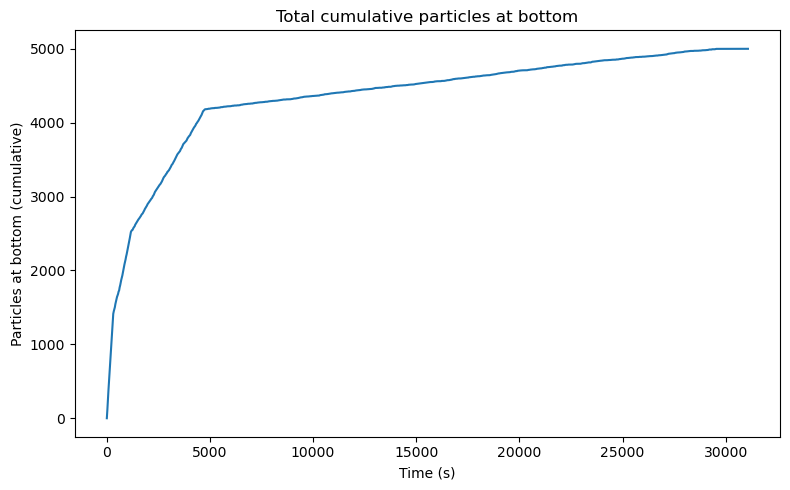

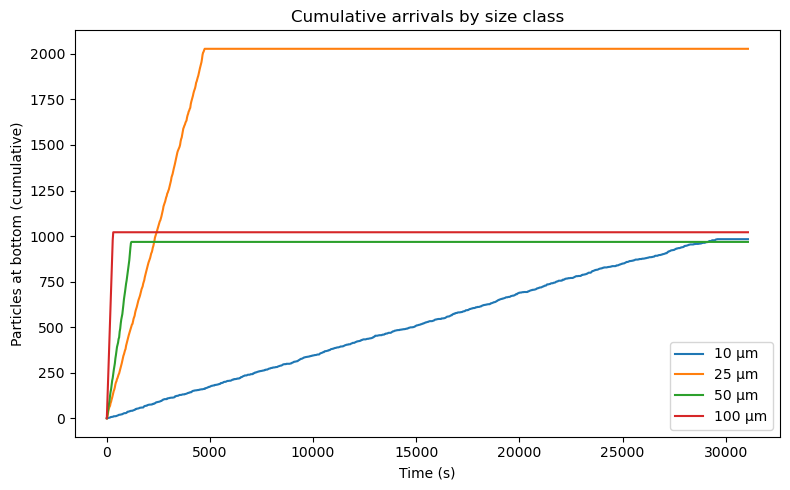

   time_s  particle_id       y_m  size_um  v_m_per_s  has_hit_bottom
0     0.0            1  0.060656     50.0   0.000094           False
1     0.0            2  0.100952    100.0   0.000375           False
2     0.0            3  0.066596     50.0   0.000094           False
3     0.0            4  0.033835     25.0   0.000023           False
4     0.0            5  0.073591     25.0   0.000023           False


In [11]:
# -----------------
# make it useful
# -----------------
if __name__ == "__main__":
    sizes = [10, 25, 50, 100]      # discrete size classes (µm)
    probs = [0.2, 0.4, 0.2, 0.2]   # optional mixing probabilities (sum to 1)

    df_mix, times, cum_total, cum_by_size,t_hit_each, size_assign = simulate_settling_dataframe_mixture(
        sizes_um=sizes,
        num_cells=5000,
        syringe_height_cm=11.0998,
        size_probs=probs,
        cell_density=1100.0,
        fluid_density=1025.0,
        fluid_viscosity= 0.00109,
        gravity=9.81,
        num_time_steps=1200,
        random_seed=7
    )

    # Plots
    plot_cumulative_total(times, cum_total)#, save_path="../Figs/StokesCumulativeParticles.png")
    plot_cumulative_by_size(times, cum_by_size)#,  save_path="../Figs/StokesCumulativeParticlesBySize.png")

    # Inspect the first few rows
    print(df_mix.head())

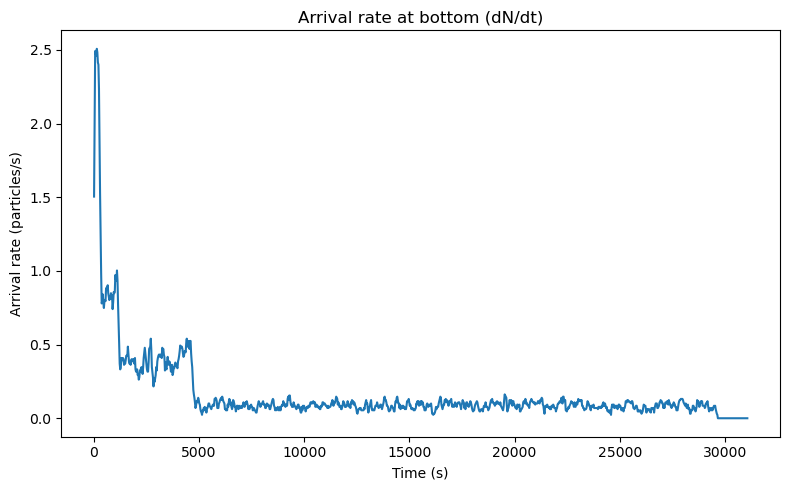

(array([1.29605671e+01, 3.88817014e+01, 6.48028357e+01, ...,
        3.10146372e+04, 3.10405583e+04, 3.10664794e+04], shape=(1199,)),
 array([1.50456379, 1.9752222 , 2.49217489, ..., 0.        , 0.        ,
        0.        ], shape=(1199,)))

In [7]:
plot_arrival_rate(times, cum_total, smooth_window=5)#,  save_path="../Figs/StokesArivalRate.png")


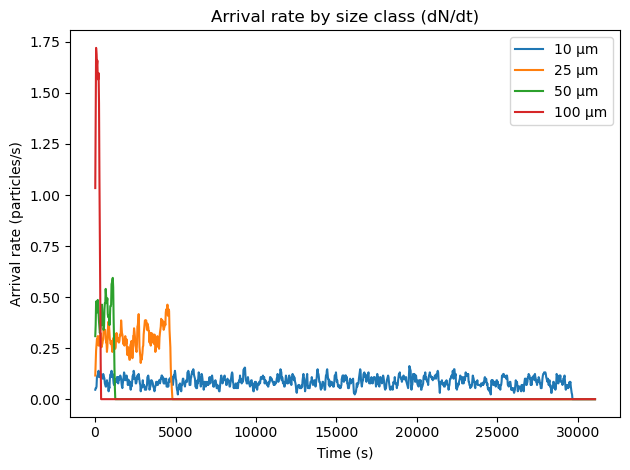

{10.0: (array([1.29605671e+01, 3.88817014e+01, 6.48028357e+01, ...,
         3.10146372e+04, 3.10405583e+04, 3.10664794e+04], shape=(1199,)),
  array([0.04629427, 0.05400998, 0.05400998, ..., 0.        , 0.        ,
         0.        ], shape=(1199,))),
 25.0: (array([1.29605671e+01, 3.88817014e+01, 6.48028357e+01, ...,
         3.10146372e+04, 3.10405583e+04, 3.10664794e+04], shape=(1199,)),
  array([0.11573568, 0.17746137, 0.23918706, ..., 0.        , 0.        ,
         0.        ], shape=(1199,))),
 50.0: (array([1.29605671e+01, 3.88817014e+01, 6.48028357e+01, ...,
         3.10146372e+04, 3.10405583e+04, 3.10664794e+04], shape=(1199,)),
  array([0.30862847, 0.36263845, 0.47837413, ..., 0.        , 0.        ,
         0.        ], shape=(1199,))),
 100.0: (array([1.29605671e+01, 3.88817014e+01, 6.48028357e+01, ...,
         3.10146372e+04, 3.10405583e+04, 3.10664794e+04], shape=(1199,)),
  array([1.03390537, 1.3811124 , 1.72060372, ..., 0.        , 0.        ,
         0.       

In [8]:
plot_arrival_rate_by_size(times, cum_by_size, smooth_window=5)#,  save_path="../Figs/StokesArivalRateBySize.png")

## what I want to do next is some simple way to incorporate both arrival and inhibition -- meaning that it keeps track of when arrivals happen over time maybe this becomes a new data frame -- I think it does this already
### then I can just start from he beginning and use some logic that is basically give each arival a binary counted or not based on starting from the first one then add the average inhibit time label all of those not seen, go to the next arival and repeat. Super similar logic to what we did for the inhibit time maps 

In [9]:
print(times)
print(cum_by_size)

[0.00000000e+00 2.59211343e+01 5.18422686e+01 ... 3.10275977e+04
 3.10535189e+04 3.10794400e+04]
{10.0: array([   0,    2,    4, ..., 2557, 2557, 2557], shape=(1200,)), 25.0: array([   0,    3,    5, ..., 1422, 1422, 1422], shape=(1200,)), 50.0: array([  0,  20,  34, ..., 531, 531, 531], shape=(1200,)), 100.0: array([  0,  41,  90, ..., 490, 490, 490], shape=(1200,))}


In [10]:
import pandas as pd
import numpy as np

def build_arrival_events_dataframe(t_hit_each: np.ndarray, size_assign: np.ndarray):
    """
    Build an event-level dataframe with one row per particle arrival.

    Parameters
    ----------
    t_hit_each : np.ndarray
        Array of first-hitting times (seconds) for each particle. Shape (N,).
    size_assign : np.ndarray
        Array of size class (µm) for each particle. Shape (N,).

    Returns
    -------
    pd.DataFrame
        Columns: [arrival_number, time_s, size_um]
        Sorted by arrival time.
    """
    df_events = pd.DataFrame({
        "time_s": t_hit_each,
        "size_um": size_assign
    })
    # Only finite times (exclude particles that never settle)
    df_events = df_events[np.isfinite(df_events["time_s"])].copy()
    # Sort by arrival time
    df_events = df_events.sort_values("time_s").reset_index(drop=True)
    # Add arrival_number
    df_events["arrival_number"] = np.arange(1, len(df_events) + 1)
    return df_events[["arrival_number", "time_s", "size_um"]]


In [11]:
events_df = build_arrival_events_dataframe(t_hit_each, size_assign)
print(events_df.head())

   arrival_number    time_s  size_um
0               1  0.711606    100.0
1               2  0.779568    100.0
2               3  1.550153     25.0
3               4  1.636377    100.0
4               5  2.492030     50.0


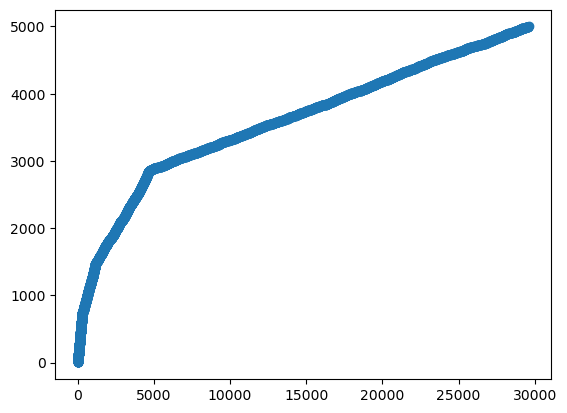

In [12]:

# prove it looks mostly like what it should
plt.scatter(events_df['time_s'],events_df['arrival_number'])
plt.show()

In [30]:
### average inhibit time is roughly 0.082 seconds so we need to exclude 

In [18]:
import numpy as np
import pandas as pd

def apply_roi_capture(events_df: pd.DataFrame, inhibit_s: float = 0.082) -> tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame]:
    """
    Tag arrivals as captured (1) or missed (0) using an inhibit window after each capture,
    and add cumulative totals: TotalCapture and TotalMiss.

    Inputs
    ------
    events_df : DataFrame
        Long/event table with at least:
          - 'time_s' (float): arrival time in seconds
          - 'size_um' (float or int): size class for the particle
        Optional:
          - 'arrival_number' (int): global arrival order (if missing, will be created)
    inhibit_s : float
        Inhibit (refractory) duration in seconds after each YES capture (default 0.082).

    Returns
    -------
    events_tagged : DataFrame
        events_df with columns added:
          - 'arrival_number' (if missing; 1-based, chronological)
          - 'RoiCapture' (int: 1=yes, 0=no)
          - 'TotalCapture' (cumulative sum of RoiCapture)
          - 'TotalMiss' (cumulative sum of 1 - RoiCapture)
    summary_overall : DataFrame
        One-row overall summary: total arrivals, captured, missed, capture_rate, missed_rate.
    summary_by_size : DataFrame
        Per-size summary with counts and rates.
    """
    required = {"time_s", "size_um"}
    missing = required - set(events_df.columns)
    if missing:
        raise ValueError(f"events_df is missing required columns: {sorted(missing)}")

    # Work on a copy; ensure sorted by time and normalized indexing
    df = events_df.copy()
    df = df[np.isfinite(df["time_s"])].sort_values("time_s").reset_index(drop=True)

    # Ensure arrival_number exists and is 1-based
    if "arrival_number" not in df.columns:
        df["arrival_number"] = np.arange(1, len(df) + 1)

    # Initialize capture tagging
    next_available_time = 0.0
    capture = np.zeros(len(df), dtype=int)

    # Step through arrivals in chronological order
    for i, t in enumerate(df["time_s"].values):
        if t >= next_available_time:
            capture[i] = 1          # YES capture
            next_available_time = t + inhibit_s
        else:
            capture[i] = 0          # NO (inhibited)

    df["RoiCapture"] = capture.astype(int)

    # Cumulative totals
    df["TotalCapture"] = df["RoiCapture"].cumsum().astype(int)
    df["TotalMiss"] = (1 - df["RoiCapture"]).cumsum().astype(int)

    # ----- Summaries -----
    total = len(df)
    captured = int(df["RoiCapture"].sum())
    missed = total - captured
    summary_overall = pd.DataFrame({
        "total_arrivals": [total],
        "captured": [captured],
        "missed": [missed],
        "capture_rate": [captured / total if total else np.nan],
        "missed_rate": [missed / total if total else np.nan],
        "inhibit_s": [inhibit_s],
    })

    # By size class
    grp = df.groupby("size_um")["RoiCapture"].agg(
        captured="sum",
        total="count"
    ).reset_index()
    grp["missed"] = grp["total"] - grp["captured"]
    grp["capture_rate"] = grp["captured"] / grp["total"]
    grp["missed_rate"] = grp["missed"] / grp["total"]
    grp = grp.sort_values("size_um").reset_index(drop=True)
    summary_by_size = grp

    return df, summary_overall, summary_by_size


In [19]:
events_tagged, overall, by_size = apply_roi_capture(events_df, inhibit_s=0.082)

In [20]:
print(overall)     # total captured/missed + rates
print(by_size)     # distribution by size class
print(events_tagged.head())  # shows RoiCapture per arrival

   total_arrivals  captured  missed  capture_rate  missed_rate  inhibit_s
0            5000      4768     232        0.9536       0.0464      0.082
   size_um  captured  total  missed  capture_rate  missed_rate
0     10.0      2513   2557      44      0.982792     0.017208
1     25.0      1364   1422      58      0.959212     0.040788
2     50.0       482    531      49      0.907721     0.092279
3    100.0       409    490      81      0.834694     0.165306
   arrival_number    time_s  size_um  RoiCapture  TotalCapture  TotalMiss
0               1  0.711606    100.0           1             1          0
1               2  0.779568    100.0           0             1          1
2               3  1.550153     25.0           1             2          1
3               4  1.636377    100.0           1             3          1
4               5  2.492030     50.0           1             4          1


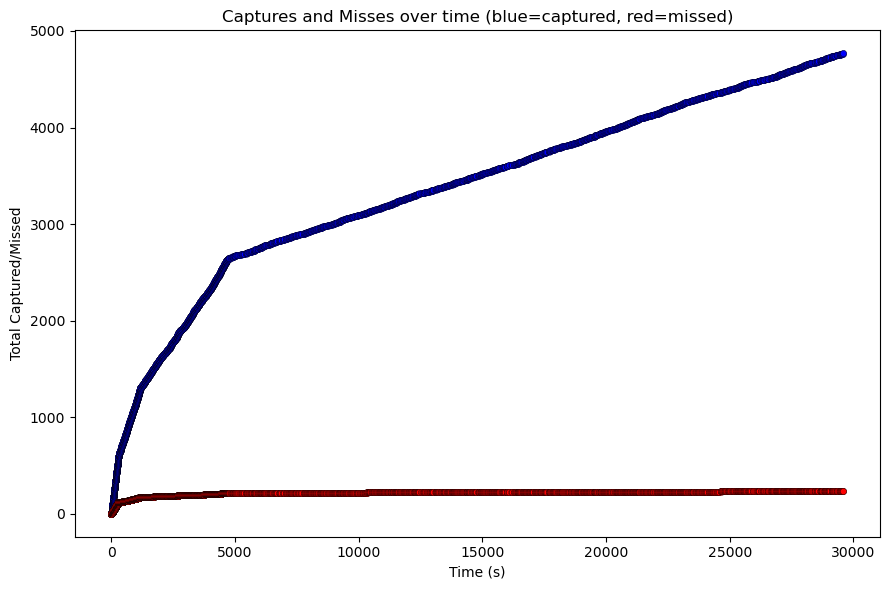

In [26]:

# Map RoiCapture (1/0) to colors
colors = events_tagged["RoiCapture"].map({1: "blue", 0: "red"})

plt.figure(figsize=(9, 6))
plt.scatter(events_tagged["time_s"], events_tagged["TotalCapture"],
            c='blue', s=20, alpha=0.7, edgecolor="k", linewidth=0.3)
plt.scatter(events_tagged["time_s"], events_tagged["TotalMiss"],
            c="red", s=20, alpha=0.7, edgecolor="k", linewidth=0.3)
plt.xlabel("Time (s)")
plt.ylabel("Total Captured/Missed")
plt.title("Captures and Misses over time (blue=captured, red=missed)")

plt.tight_layout()
plt.show()


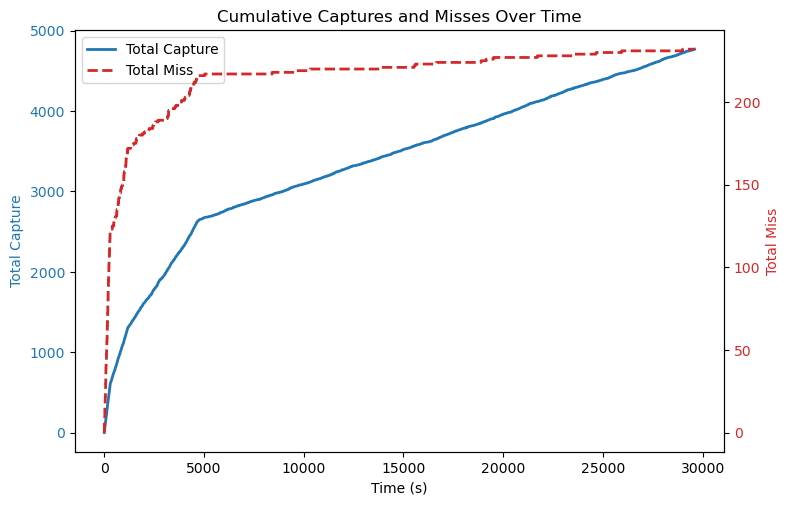

In [25]:
import matplotlib.pyplot as plt

# Assuming df is the events_tagged DataFrame returned by apply_roi_capture()
# and includes: 'time_s', 'TotalCapture', 'TotalMiss'

fig, ax1 = plt.subplots(figsize=(8, 5))

# Left y-axis: TotalCapture
color1 = 'tab:blue'
ax1.plot(events_tagged["time_s"], events_tagged["TotalCapture"], color=color1, label="Total Capture", linewidth=2)
ax1.set_xlabel("Time (s)")
ax1.set_ylabel("Total Capture", color=color1)
ax1.tick_params(axis="y", labelcolor=color1)

# Second y-axis: TotalMiss (scaled to same x-axis)
ax2 = ax1.twinx()
color2 = 'tab:red'
ax2.plot(events_tagged["time_s"], events_tagged["TotalMiss"], color=color2, label="Total Miss", linewidth=2, linestyle="--")
ax2.set_ylabel("Total Miss", color=color2)
ax2.tick_params(axis="y", labelcolor=color2)

# Optional: align the zero lines and clean up layout
fig.tight_layout()

# Add combined legend
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines + lines2, labels + labels2, loc="upper left")

plt.title("Cumulative Captures and Misses Over Time")
plt.show()


### how might we show both the distribution of misses over time and how that changes as we tweak the model inputs
#### one idea is just cumulative misses and hits over time as two seperate lines
#### should step through and make like 5 model outputs moving from most simple to more complex and with diff input and size distribs just to see how the model behaves 